# Bank Marketing

This dataset is public available for research. The details are described in [Moro et al., 2011]. 
Please include this citation if you plan to use this database:

[Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

Available at: [pdf] http://hdl.handle.net/1822/14838
            [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

## Input variables:
### bank client data:
* 1 - age (numeric)
* 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
* 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
* 4 - education (categorical: "unknown","secondary","primary","tertiary")
* 5 - default: has credit in default? (binary: "yes","no")
* 6 - balance: average yearly balance, in euros (numeric) 
* 7 - housing: has housing loan? (binary: "yes","no")
* 8 - loan: has personal loan? (binary: "yes","no")

### Related with the last contact of the current campaign:
* 9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
* 10 - day: last contact day of the month (numeric)
* 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
* 12 - duration: last contact duration, in seconds (numeric)

### Other attributes:
* 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
* 15 - previous: number of contacts performed before this campaign and for this client (numeric)
* 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

### Output variable (desired target):
* 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# Table of contents

* [Split Dataset train / test](#split_train_test)
* [Check for distribution mismatch between train/test set](#check_dist_mismatch)


* Check missing values
* Check correlations
* Univariate AUC
* Exploratory Decision Tree
* [Bivariate analysis](#bivariate_analysis)


* Undersample majority class
* Check for distribution mismatch between undersampled sample and population <br>

In [1]:
from IPython.display import display, HTML

from time import time
import numpy as np
import bisect
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from support_files.adversarial_validation import adversarial_validation
from support_files.CategoricalEncoder import CategoricalEncoder
from support_files.categorical_dist_test import categorical_dist_test
from support_files.undersample import undersample
from support_files.statistical_preproc import univ_auc, correlation_analysis
from support_files.optimized_bins import get_optimized_bins
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize, BayesSearchCV, forest_minimize
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import graphviz
import pydotplus
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

pd.set_option("display.max_columns", 150, "display.max_colwidth", 150)
pd.options.display.max_rows = 1000

In [2]:
# Show all columns
pd.set_option('display.max_columns', None)

# Option for wider notebook cells
display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
dataset = pd.read_csv("./data/bank-full.csv", sep=";")

In [4]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
dataset["Month"] = dataset["month"].map({"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, 
                                          "sep":9, "oct":10, "nov":11, "dec":12})
dataset["default_in_loan"] = dataset["default"].map({'no':0, 'yes':1})
dataset["housing_loan"] = dataset["housing"].map({'no':0, 'yes':1})
dataset["personal_loan"] = dataset["loan"].map({'no':0, 'yes':1})
dataset["prob_outcome"] = np.where(dataset["poutcome"] == "success", 1, 0)
dataset["target"] = dataset["y"].map({'no':0, 'yes':1})

dataset = dataset.drop(["month","default","housing","loan", "poutcome","y"], axis=1)

dataset['id'] = range(len(dataset))

In [6]:
discard = ["target", "id"]
categorical_vars = [x for x in list(dataset.select_dtypes(include="object").columns) if x not in discard]
bool_vars = [x for x in list(dataset.select_dtypes(include="bool").columns) if x not in discard]
numerical_vars = [x for x in list(dataset.select_dtypes(include=["int","float"]).columns) if x not in discard]

In [7]:
dataset.head()

,age,job,marital,education,balance,contact,day,duration,campaign,pdays,previous,Month,default_in_loan,housing_loan,personal_loan,prob_outcome,target,id
0,58,management,married,tertiary,2143,unknown,5,261,1,-1,0,5,0,1,0,0,0,0
1,44,technician,single,secondary,29,unknown,5,151,1,-1,0,5,0,1,0,0,0,1
2,33,entrepreneur,married,secondary,2,unknown,5,76,1,-1,0,5,0,1,1,0,0,2
3,47,blue-collar,married,unknown,1506,unknown,5,92,1,-1,0,5,0,1,0,0,0,3
4,33,unknown,single,unknown,1,unknown,5,198,1,-1,0,5,0,0,0,0,0,4


<a id='split_train_test'></a>
#### Get train and test set from the original dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset, dataset.target, test_size=0.3, random_state=55555)

In [9]:
data_train = X_train.copy().reset_index(drop=True)
data_train["target"] = y_train.reset_index(drop=True)

data_test = X_test.copy().reset_index(drop=True)
data_test["target"] = y_test.reset_index(drop=True)

In [10]:
print(data_train.target.mean())
print(data_test.target.mean())
print()
print(data_train.target.sum())
print(data_test.target.sum())

0.11748348974626346
0.11582129165437924

3718
1571


#### We need to perform 2 steps:
* We have an event rate of ~11% in both train and test samples - we will balance these samples with 2:1 odds (2 parts non-event, 1 part event)
* Then, we will perform adversarial validation on the obtained samples to check: <br>
    1 - If the sampled population in the train set comes from the same distribution of the test set: <br>
    2 - If the samples come from the same distribution of the population they were samples from <br>
* If they don't come from the same distribution we will choose the observations more similar to the ones in the population/test set

<a id='check_dist_mismatch'></a>
## Check Distribution mismatch between train/test set

In [11]:
adv = adversarial_validation(data_train.copy(), data_test.copy(), "target", "id", 
                        RandomForestClassifier( n_estimators=200, max_depth=5, n_jobs = -1, random_state=55555 ))

In [12]:
adv_val_set, predictions = adv.check_dist()

AUC is: 0.5011083308530179


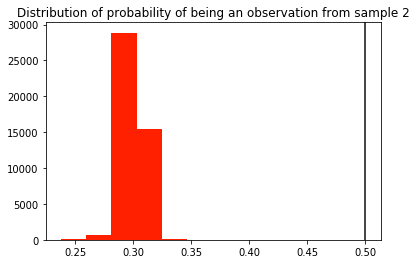

In [13]:
adv_val_set_probs = adv.get_scored_obs(adv_val_set, predictions, get_plot=True)

#### If we have different distributions on the samples we can:
* Remove observations with low probability from sample_1 (making sample_1 more similar to sample_2)
* Transfer observations with low probability on sample_1 to sample_2 (making sample_2 more similar to sample_1)
* Choose another sample_2

## Univariate analysis

#### Check for missing values

In [14]:
data_train.isnull().sum() / data_train.shape[0]

age                0.0
job                0.0
marital            0.0
education          0.0
balance            0.0
contact            0.0
day                0.0
duration           0.0
campaign           0.0
pdays              0.0
previous           0.0
Month              0.0
default_in_loan    0.0
housing_loan       0.0
personal_loan      0.0
prob_outcome       0.0
target             0.0
id                 0.0
dtype: float64

#### Histograms

/Users/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


KeyboardInterrupt: 

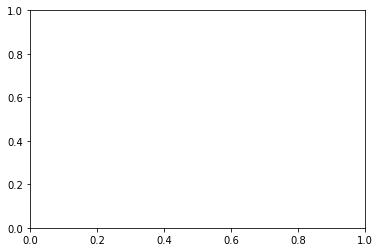

In [12]:
sn.kdeplot(data_train[numerical_vars], shade=True)

In [ ]:
g = sns.FacetGrid(pd.melt(data_train,
                      id_vars=['id1','id2'],
                      value_vars=[numerical_vars]),
              hue='id1',col='id2',row='variable')
g.map(sns.kdeplot,'value')

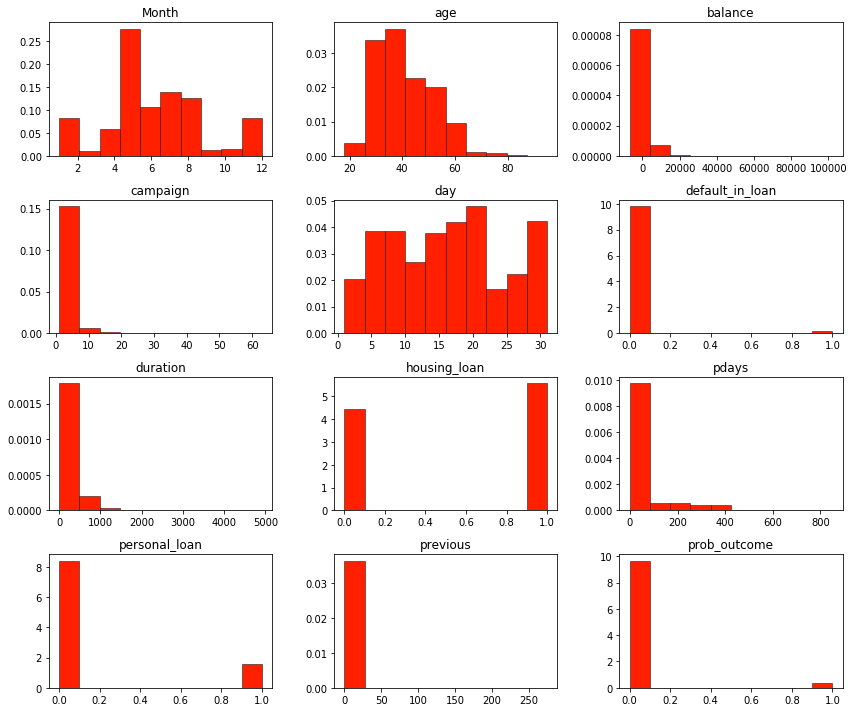

In [15]:
data_train[numerical_vars].hist(figsize=(12,10), density=True, color="#FF2000", 
                                edgecolor='#0C0C0C', linewidth=0.5, grid=False)
plt.tight_layout()
plt.show()

<a id='bivariate_analysis'></a>
## Bivariate analysis

#### Correlation analysis

In [16]:
corr, corr_net = correlation_analysis(data_train.drop("id", axis=1), corr_limit=0.6)

In [17]:
corr

,variable 1,variable 2,correlation


In [18]:
corr_net

,Variable,# Correlations > limit


#### Univariate AUC

In [19]:
univ_enc = CategoricalEncoder()

In [20]:
univ_data_train = univ_enc.fit_transform(data_train.copy())

In [21]:
univ_auc_df = univ_auc(univ_data_train, list(univ_data_train), "target")

In [22]:
univ_auc_df[univ_auc_df["AUC"] > 0.55]

,variable,AUC
1,balance,0.593015
3,duration,0.806143
4,campaign,0.571273
5,pdays,0.592637
6,previous,0.601961
9,housing_loan,0.606606
11,prob_outcome,0.585209
12,target,1.000000
36,contact==cellular,0.599695
39,contact==unknown,0.605106


#### Exploratory Decision Tree

In [61]:
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(univ_data_train[list(univ_data_train)].drop("id", axis=1), univ_data_train.target)

In [62]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=list(univ_data_train[list(univ_data_train)].drop("id", axis=1)),  
                         class_names=["goods", "bads"],  
                         filled=True, rounded=True,  
                         special_characters=True,
                        proportion=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  

graph.write_png('./tree.png')

True

#### Optimized bins against the event rate

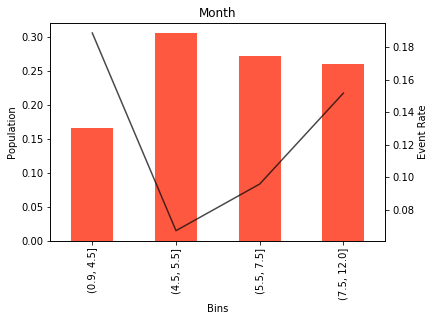

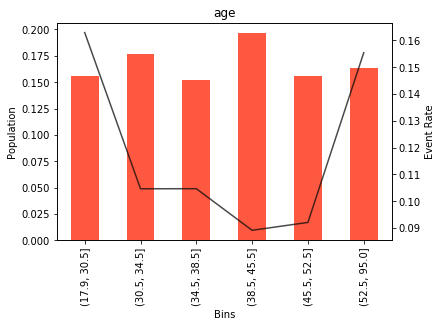

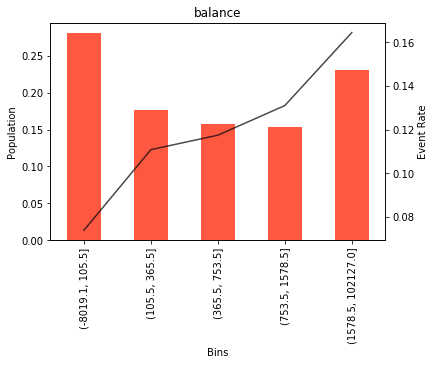

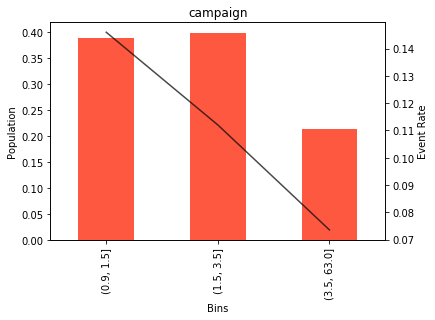

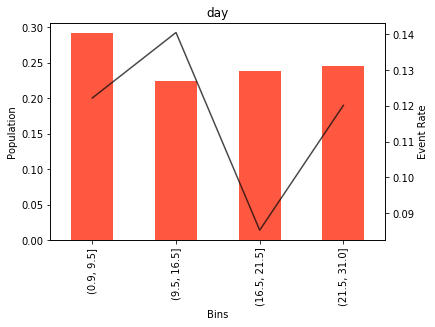

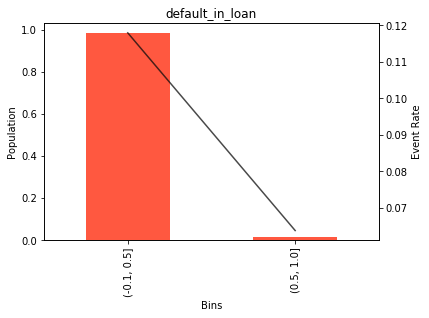

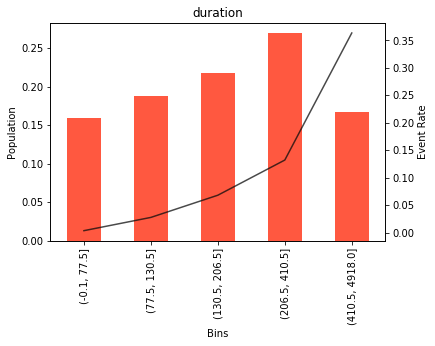

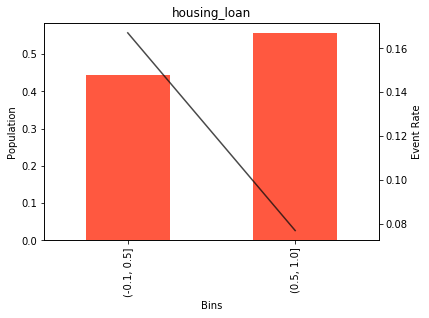

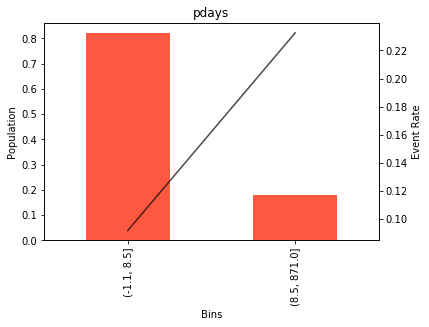

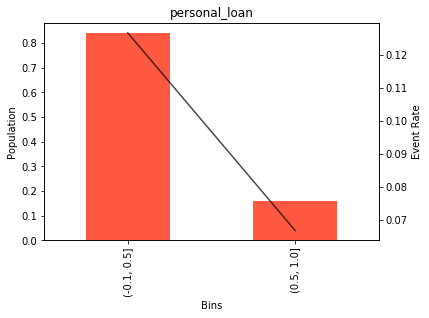

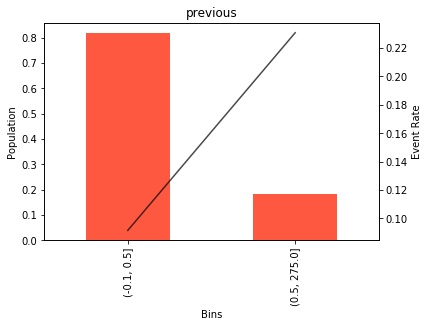

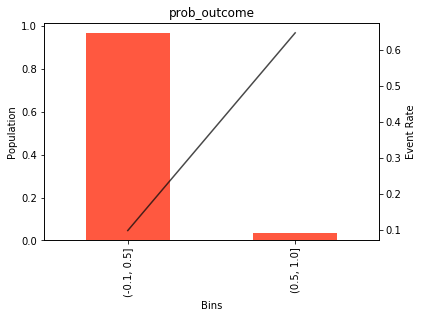

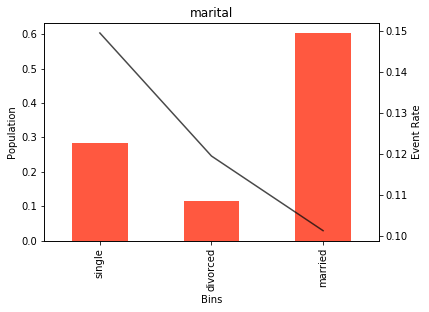

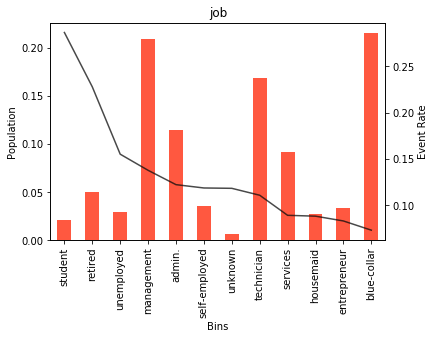

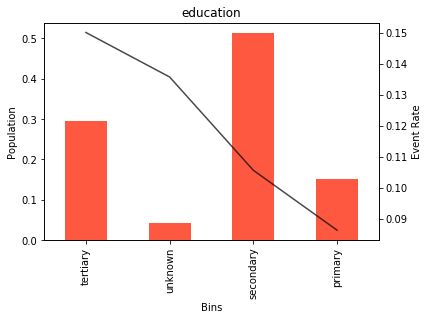

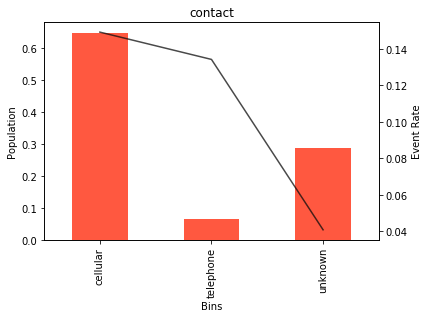

In [23]:
get_optimized_bins(dataset, "target", "id", list(dataset), min_bin_percent=0.15, get_plots=True);

## Undersample class 0
## 2:1 odds - Check for distribution mismatch

In [24]:
data_train_2_1 = undersample(data_train.copy(), "target", 2, 55555)

In [25]:
population_0 = data_train[data_train["target"]==0].copy()
undersample_0 = data_train_2_1[data_train_2_1["target"]==0].copy()

In [26]:
adv_2_1_sample = adversarial_validation(population_0, undersample_0, "target", "id", 
                                        RandomForestClassifier( n_estimators=200, max_depth=3, n_jobs = -1, random_state=55555 ))

In [27]:
population_0.head()

,age,job,marital,education,balance,contact,day,duration,campaign,pdays,previous,Month,default_in_loan,housing_loan,personal_loan,prob_outcome,target,id
0,57,self-employed,divorced,tertiary,6519,cellular,20,1040,1,-1,0,11,0,0,0,0,0,26300
1,38,management,single,tertiary,5244,cellular,8,310,4,-1,0,8,0,0,0,0,0,19961
2,43,technician,divorced,secondary,1648,cellular,17,80,1,-1,0,11,0,0,0,0,0,24211
3,41,admin.,married,secondary,338,unknown,16,121,1,-1,0,5,0,1,0,0,0,3866
5,51,housemaid,single,primary,723,cellular,29,51,1,-1,0,1,0,0,0,0,0,28468


In [28]:
adv_2_1_val_set, predictions_2_1 = adv_2_1_sample.check_dist()

AUC is: 0.4714475599783675


### Train a model

In [29]:
#Setup the hyperparameter grid
param_distributions = {'RF__max_depth' :  Integer(2, 7),
                        'RF__n_estimators' : Integer(75, 150)}

#Create a classifier instance
pipe_1 = Pipeline(steps=[('catencoder', CategoricalEncoder()), 
                       ('RF', RandomForestClassifier(random_state=77777))])

#Instantiate the BayesSearchCV object
pipe_1_cv = BayesSearchCV(pipe_1, param_distributions, {'base_estimator': 'RF'}, 
                          scoring='roc_auc', cv=3, n_iter=30, random_state=77777)

In [30]:
# Fit it to the data
start = time()
pipe_1_cv.fit(data_train_2_1.drop("target", axis=1), data_train_2_1.target)
end = time()
print('Bayesian Search fitting time: ' + str(end-start))

/Users/hveiga/Desktop/Data_Science/dl-venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Bayesian Search fitting time: 58.65283012390137


In [31]:
# Print the best tuned parameters and score
print
print("Tuned model best parameters: {}".format(pipe_1_cv.best_params_))
print("Best mean score is {}".format(pipe_1_cv.best_score_))

Tuned model best parameters: {'RF__max_depth': 7, 'RF__n_estimators': 93}
Best mean score is 0.9337220791811615


Predict on the test set

In [33]:
roc_auc_score(data_test.target, pipe_1_cv.predict_proba(data_test.drop("target", axis=1))[:, 1])

0.9395868680664188

#### Get featu importances

In [ ]:
pipe_1_cv.best_estimator_.

#### Precision / Recall

In [35]:
print(classification_report( data_test.target, pipe_1_cv.predict(data_test.drop("target", axis=1))))

             precision    recall  f1-score   support

          0       0.97      0.90      0.94     11993
          1       0.52      0.80      0.63      1571

avg / total       0.92      0.89      0.90     13564



#### Confusion Matrix

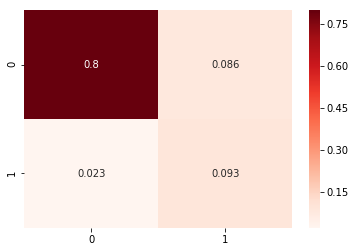

In [42]:
conf_matrix = confusion_matrix(data_test.target, pipe_1_cv.predict(data_test.drop("target", axis=1)))
sn.heatmap(pd.DataFrame(conf_matrix / conf_matrix.sum() ), annot=True, cmap=plt.cm.Reds)